# Data Analysis

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

## Introduction

- Crispdm problema
- The dataset
- Business Questions

## Python ETL

### Loading data

In [103]:
folder = 'FoodData_Central_foundation_food_csv_2025-04-24'
# Read all relevant CSVs as string columns

foods = pd.read_csv(os.path.join(folder, 'food.csv'), dtype=str)
category = pd.read_csv(os.path.join(folder, 'food_category.csv'), dtype=str)

nutrients = pd.read_csv(os.path.join(folder, 'nutrient.csv'), dtype=str)
food_nutrients = pd.read_csv(os.path.join(folder, 'food_nutrient.csv'), dtype=str)

food_nutrient_conversion_factor = pd.read_csv(os.path.join(folder, 'food_nutrient_conversion_factor.csv'), dtype=str)
calorie_factor = pd.read_csv(os.path.join(folder, 'food_calorie_conversion_factor.csv'), dtype=str)

### Data Transformations

In [104]:
# Data preparation: renaming columns and converting data types
nutrients = nutrients.rename(
    columns={'id': 'nutrient_id', 'name': 'nutrient_name'}
)

category = category.rename(
    columns={'id': 'food_category_id', 'description': 'food_category'}
)

food_nutrient_conversion_factor = food_nutrient_conversion_factor.rename(
    columns={'id': 'food_nutrient_conversion_factor_id'}
)

foods = foods[['fdc_id', 'description', 'food_category_id']]
food_nutrients['amount'] = pd.to_numeric(food_nutrients['amount'], errors='coerce')

calorie_factor['protein_value'] = calorie_factor['protein_value'].astype(float)
calorie_factor['carbohydrate_value'] = calorie_factor['carbohydrate_value'].astype(float)
calorie_factor['fat_value'] = calorie_factor['fat_value'].astype(float)

In [105]:
# Join nutrient names to food_nutrients
food_nutrients = food_nutrients.merge(nutrients, 
                    on='nutrient_id',
                    how='left')

# Identify top 10 most common nutrients
top_nutrients = (
    food_nutrients.groupby('nutrient_id')['fdc_id']
    .count()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Force add some relevant nutrients if not in top 10
target_names = ['Carbohydrates', 'Carbohydrate, by difference', 'Carbohydrate, other', 'Total lipid (fat)', 'Protein']
for name in target_names:
    nutrient_id = nutrients.loc[nutrients['nutrient_name'] == name, 'nutrient_id'].values
    if len(nutrient_id) > 0 and nutrient_id[0] not in top_nutrients:
        top_nutrients = top_nutrients.append(pd.Index([nutrient_id[0]]))

# Filter food_nutrients to keep only those top 10 nutrients
food_nutrients = food_nutrients[food_nutrients['nutrient_id'].isin(top_nutrients)]

# Pivot the table to have nutrients as columns
nutrients_pivot = food_nutrients.pivot_table(
    index='fdc_id',
    columns='nutrient_name',
    values='amount',
    aggfunc='mean'
).reset_index()

In [106]:
# Merge calorie_factor with food_nutrient_conversion_factor to fdc_id
calorie_factor = calorie_factor.merge(food_nutrient_conversion_factor,
    on='food_nutrient_conversion_factor_id',
    how='left'
)

#### Join relational tables

In [107]:
# Add food categories to foods
foods = foods.merge(category, 
        on='food_category_id',
        how='left')

# Merge the pivoted nutrients into foods
foods = foods.merge(nutrients_pivot,
        on='fdc_id',
        how='left')

# Merge calorie_factor into foods
foods = foods.merge(calorie_factor[['fdc_id', 'protein_value', 'carbohydrate_value', 'fat_value']],
        on='fdc_id',
        how='left')

In [108]:
# Get total energy from macronutrients
foods['calculated_energy'] = (
    foods['protein_value'] * foods['Protein'] +
    foods['carbohydrate_value'] * foods['Carbohydrate, by difference'] +
    foods['fat_value'] * foods['Total lipid (fat)']
)

#### Final Ajustments

In [109]:
foods.drop(columns=['food_category_id', 'code', 'protein_value', 'carbohydrate_value', 'fat_value'], inplace=True)
foods = foods[foods['calculated_energy'].notna()]

In [110]:
foods.to_csv('cleaned_data/foods_with_nutrients.csv', index=False)

---
## Exploratory Data Analysis

### Null values and inconsistencies

In [111]:
foods.isna().sum()

fdc_id                         0
description                    0
food_category                  0
Calcium, Ca                    4
Carbohydrate, by difference    0
Copper, Cu                     4
Iron, Fe                       4
Magnesium, Mg                  4
Manganese, Mn                  4
Phosphorus, P                  4
Potassium, K                   4
Protein                        0
Total lipid (fat)              0
Water                          0
Zinc, Zn                       4
calculated_energy              0
dtype: int64

In [112]:
# There are some missing values in nutrient columns, we can fill them with 0
foods.fillna(0, inplace=True)

In [113]:
foods.describe()

,"Calcium, Ca","Carbohydrate, by difference","Copper, Cu","Iron, Fe","Magnesium, Mg","Manganese, Mn","Phosphorus, P","Potassium, K",Protein,Total lipid (fat),Water,"Zinc, Zn",calculated_energy
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,81.737737,18.771458,0.195346,1.383407,46.048155,0.587715,168.137566,297.424626,9.740826,8.688350,61.399803,1.403057,186.808079
std,175.074670,25.065880,0.346707,1.966666,72.134973,1.287582,185.778101,268.665393,10.221034,15.264196,32.417957,1.574316,174.360214
min,0.000000,-0.705000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000
25%,8.043500,2.848580,0.034928,0.150300,11.275000,0.018000,29.485000,148.850000,1.060000,0.289375,38.425000,0.209600,42.620056
50%,21.000000,7.800000,0.070000,0.531950,18.965000,0.099455,103.000000,245.050000,6.918750,1.611500,73.250000,0.620000,122.538630
75%,64.090000,20.050965,0.179475,1.838750,32.925000,0.425700,224.650000,350.450000,17.368388,9.294000,88.300000,2.412500,339.464850
max,1498.000000,99.600000,2.218000,14.210000,499.700000,11.300000,1150.000000,2480.000000,79.900000,99.100000,97.400000,7.110000,832.885800


As we can see, some nutrient values exceed 100. This occurs because the USDA data expresses nutrients in different units depending on the compound. For instance, minerals such as **calcium**, **potassium**, and **phosphorus** are measured in **milligrams (mg)**, while vitamins may be measured in **micrograms (µg)**. As a result, their numerical values can be much higher than 100 even though all values are standardized per **100 grams of food**.

Furthermore, certain foods may display **negative values** for *“Carbohydrate, by difference.”*  
This nutrient is typically **calculated indirectly** rather than measured directly — it represents what remains after subtracting the measured components (**protein**, **fat**, **water**, **ash**, and **fiber**) from 100 grams. Small rounding differences or measurement inaccuracies in these components can cause the calculated carbohydrate value to become slightly negative.


In [114]:
# Unit names of top nutrients
nutrients[nutrients['nutrient_id'].isin(top_nutrients)][['nutrient_name', 'unit_name']]

,nutrient_name,unit_name
4,Protein,G
5,Total lipid (fat),G
6,"Carbohydrate, by difference",G
52,Water,G
73,"Carbohydrate, other",G
88,"Calcium, Ca",MG
90,"Iron, Fe",MG
91,"Magnesium, Mg",MG
92,"Phosphorus, P",MG
93,"Potassium, K",MG


As we can see, the nutrient values are expressed in different units. This is not an issue for our analysis, since we will apply a StandardScaler during preprocessing to normalize all features before training the model.

### Univariate Analysis

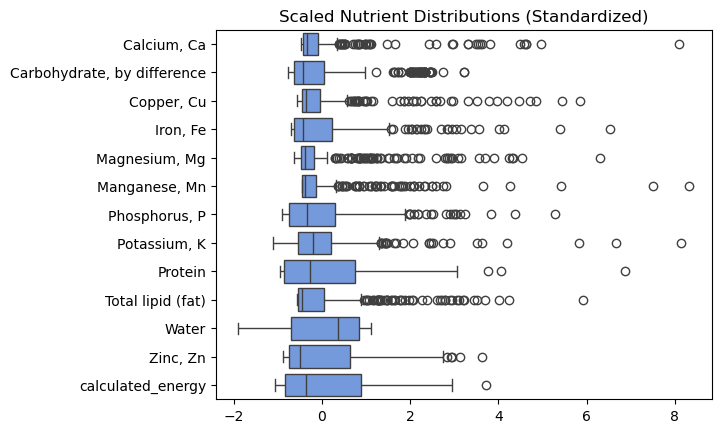

In [115]:
from sklearn.preprocessing import StandardScaler
import math
import scipy.stats as stats


nutrient_cols = foods.drop(columns=['fdc_id', 'description', 'food_category']).columns

scaled = pd.DataFrame(
    StandardScaler().fit_transform(foods[nutrient_cols]),
    columns=nutrient_cols
)

sns.boxplot(data=scaled, orient='h', color='cornflowerblue')
plt.title('Scaled Nutrient Distributions (Standardized)')
plt.show()

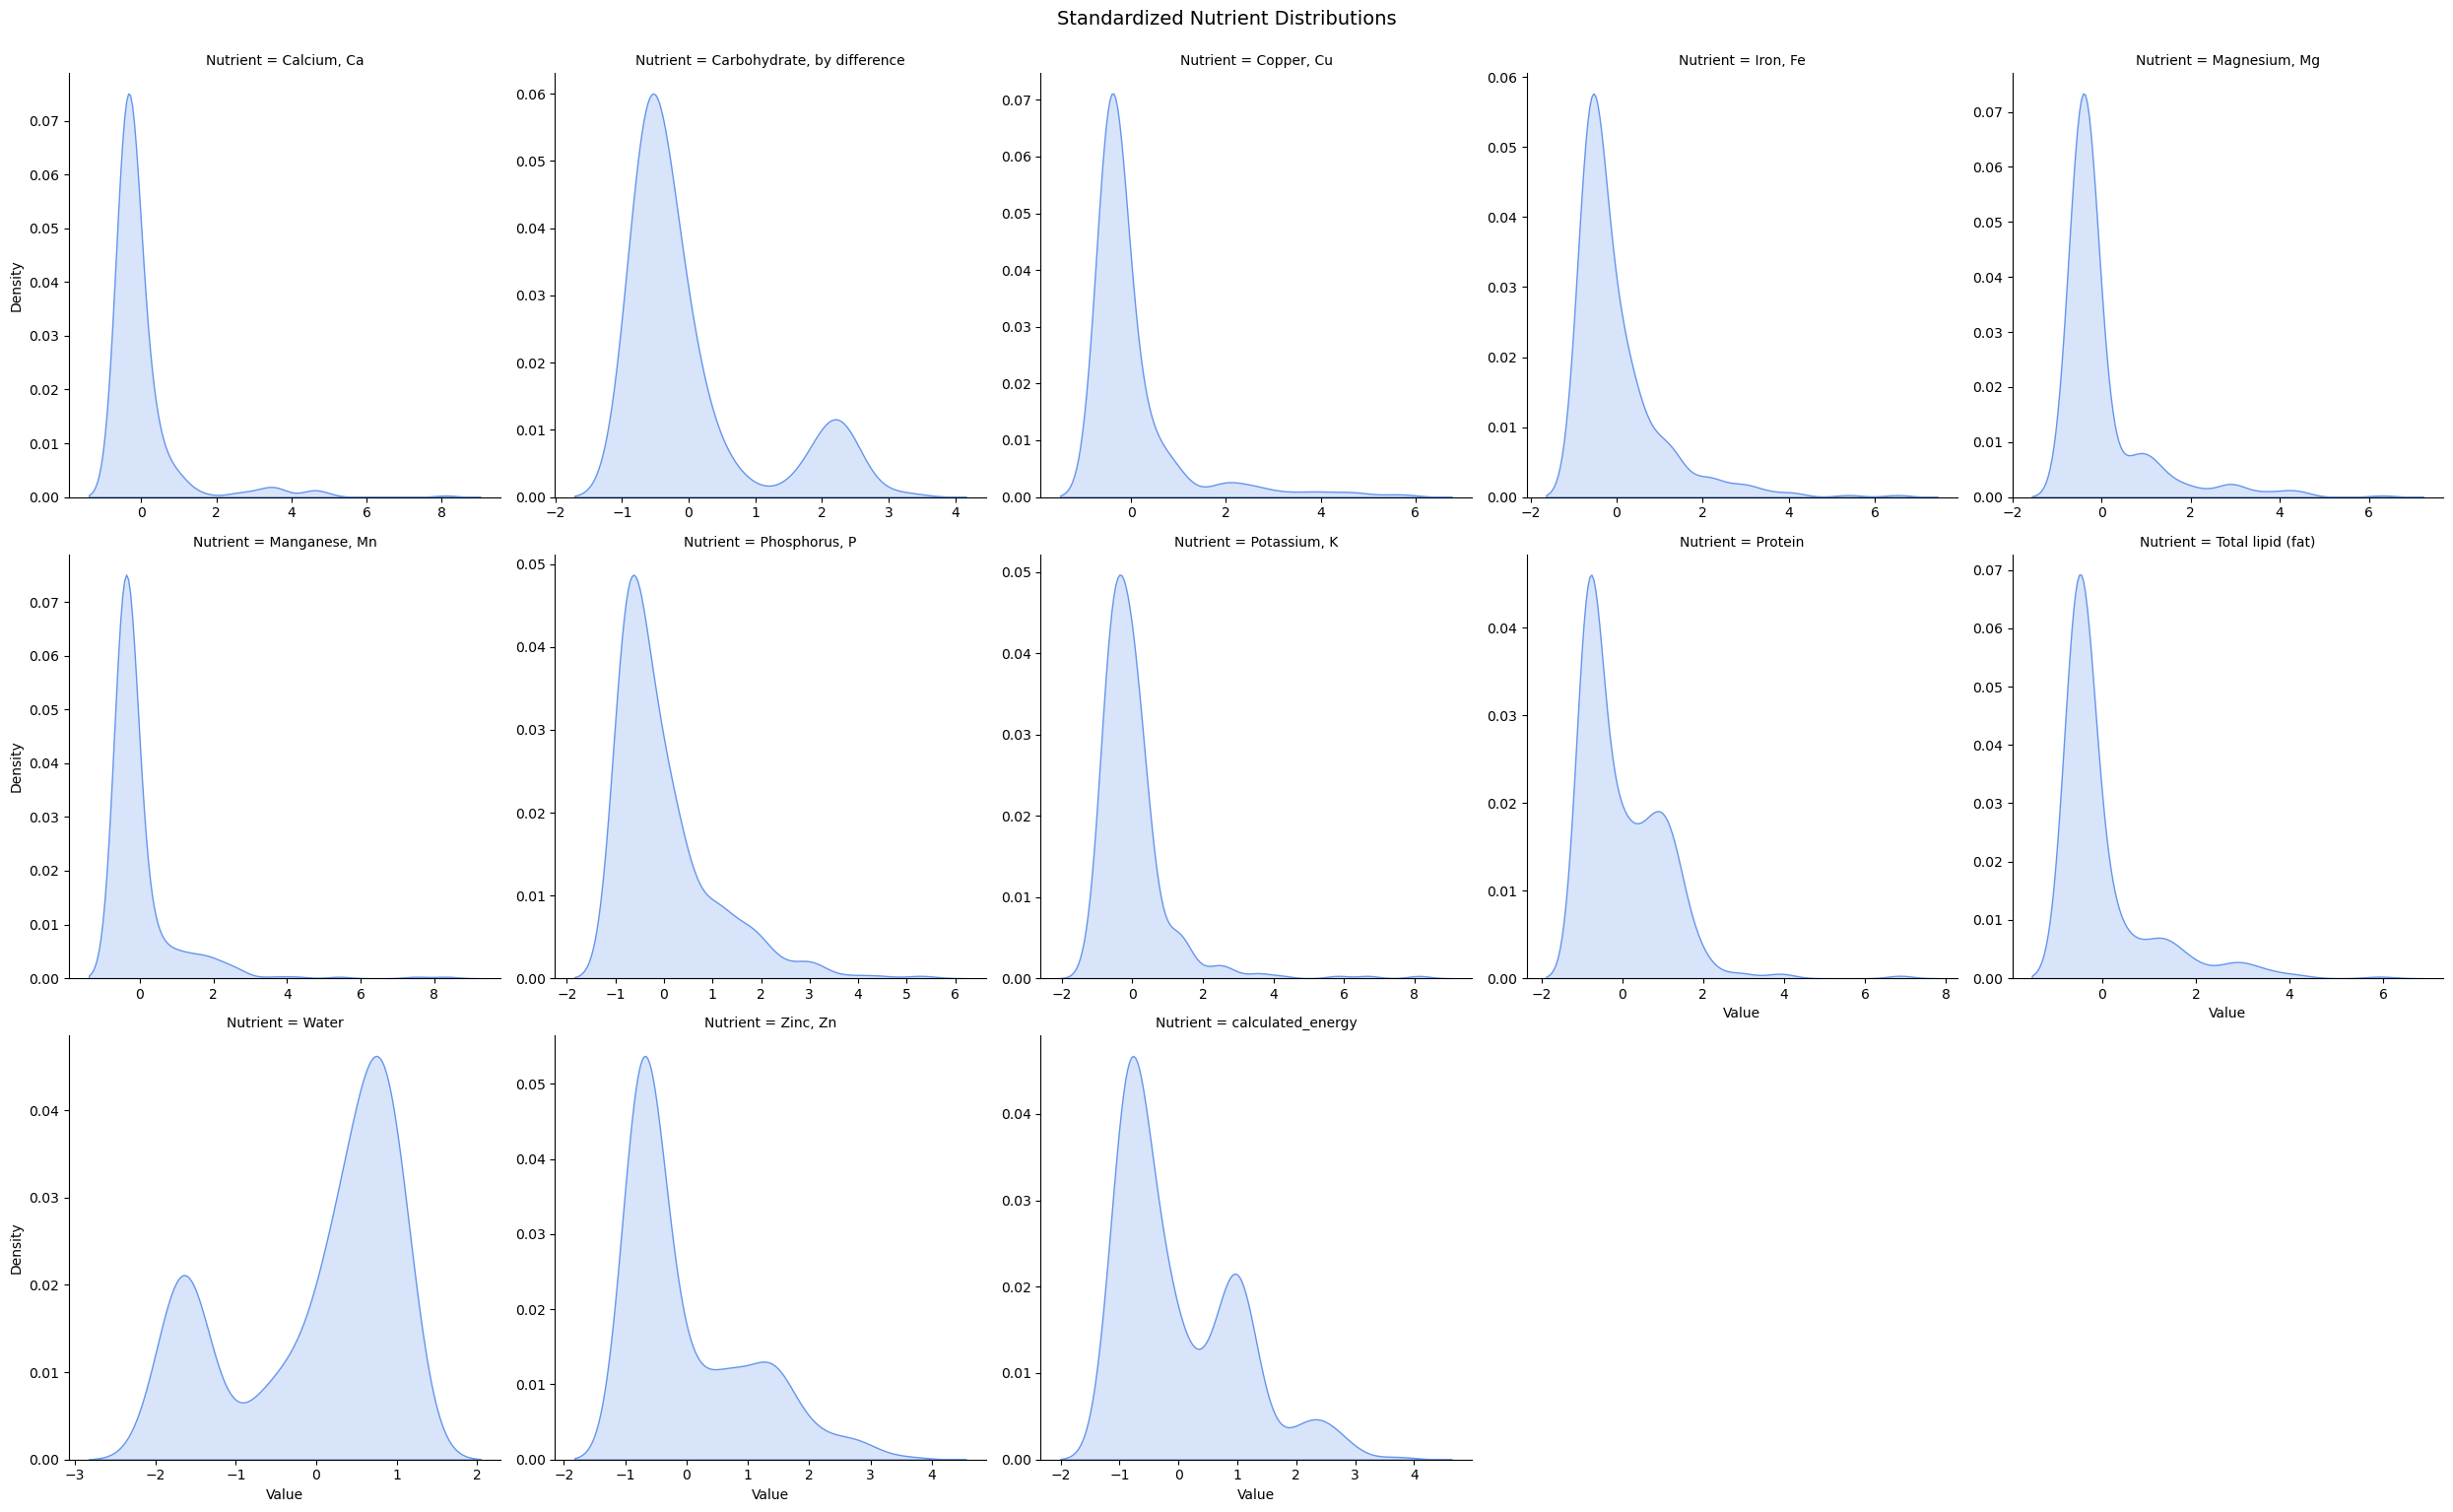

In [116]:
# Transform data to long format for Seaborn
df_melt = scaled.melt(var_name='Nutrient', value_name='Value')

# Create one distribution plot per nutrient
sns.displot(
    data=df_melt,
    x='Value',
    col='Nutrient',
    col_wrap=5, 
    kind='kde',  
    fill=True,
    facet_kws={'sharex': False, 'sharey': False},
    color='cornflowerblue'
)

plt.suptitle('Standardized Nutrient Distributions', y=1.02, fontsize=14)
plt.show()

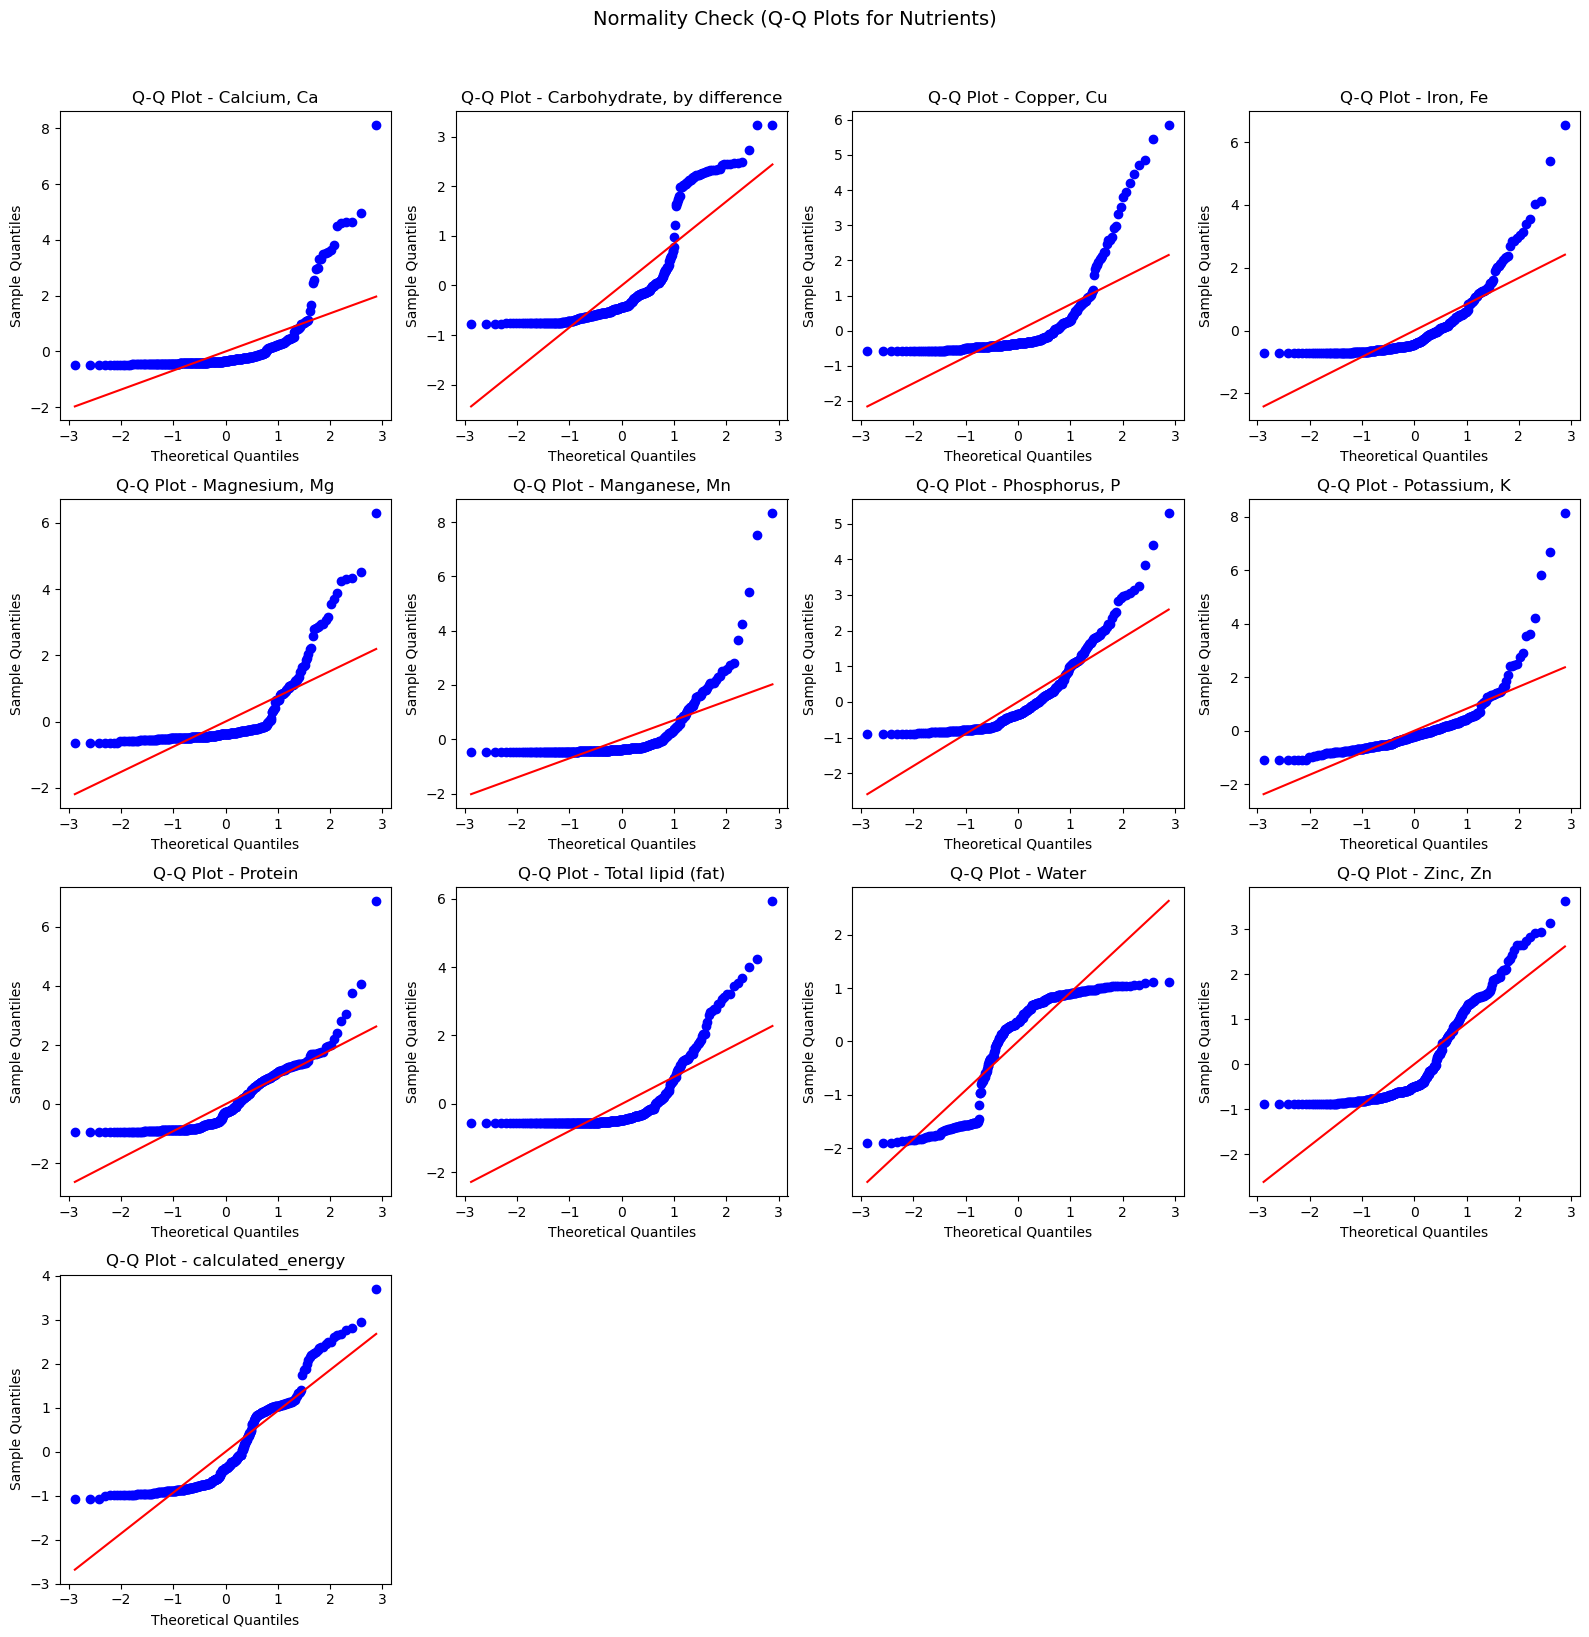

In [117]:

# Select scaled numeric columns
data = scaled.copy()  # from your StandardScaler step

# Create subplots dynamically
n_cols = 4
n_rows = math.ceil(len(data.columns) / n_cols)

plt.figure(figsize=(16, 4 * n_rows))

for i, col in enumerate(data.columns, 1):
    plt.subplot(n_rows, n_cols, i)
    stats.probplot(data[col], dist='norm', plot=plt)
    plt.title(f'Q-Q Plot - {col}')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')

plt.suptitle('Normality Check (Q-Q Plots for Nutrients)', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

In [118]:
from scipy.stats import shapiro

for col in data.columns:
    stat, p = shapiro(data[col])
    print(f'{col}: p-value = {p:.4f}')

Calcium, Ca: p-value = 0.0000
Carbohydrate, by difference: p-value = 0.0000
Copper, Cu: p-value = 0.0000
Iron, Fe: p-value = 0.0000
Magnesium, Mg: p-value = 0.0000
Manganese, Mn: p-value = 0.0000
Phosphorus, P: p-value = 0.0000
Potassium, K: p-value = 0.0000
Protein: p-value = 0.0000
Total lipid (fat): p-value = 0.0000
Water: p-value = 0.0000
Zinc, Zn: p-value = 0.0000
calculated_energy: p-value = 0.0000


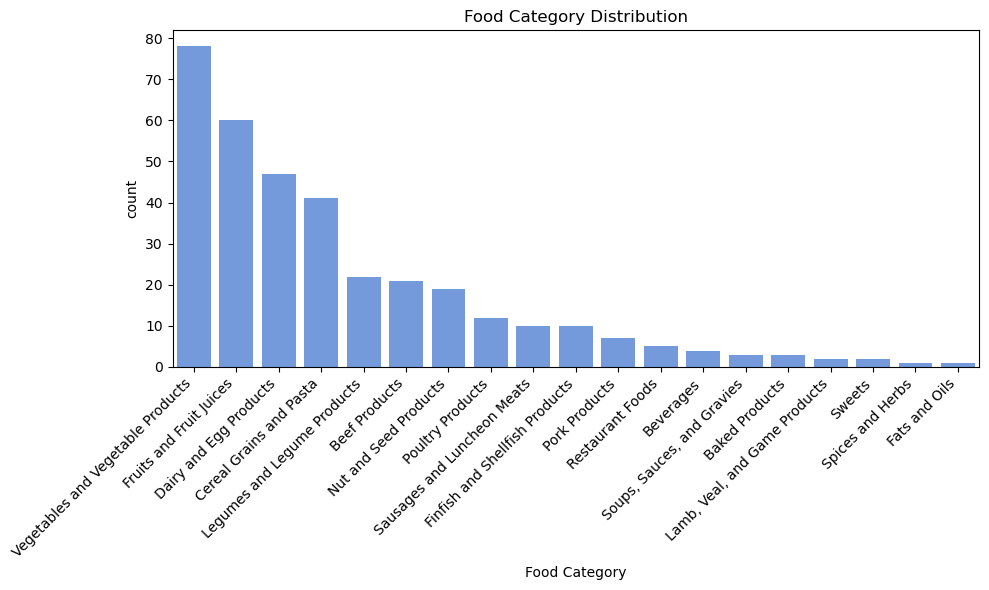

In [119]:
plt.figure(figsize=(10, 6))

sns.countplot(
    data=foods,
    x='food_category',
    order=foods['food_category'].value_counts().index,
    color='cornflowerblue'
)
plt.title('Food Category Distribution')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Food Category')
plt.tight_layout()
plt.show()

Conclusion:

- Normality is not a concern for predictive regression as long as the data is normalized/scaled.
- Additional transformations can improve stability and interpretability of linear models, but they are not mandatory.
- For tree-based or ensemble methods, non-normality does not pose any issues.

### Bivariate Analysis

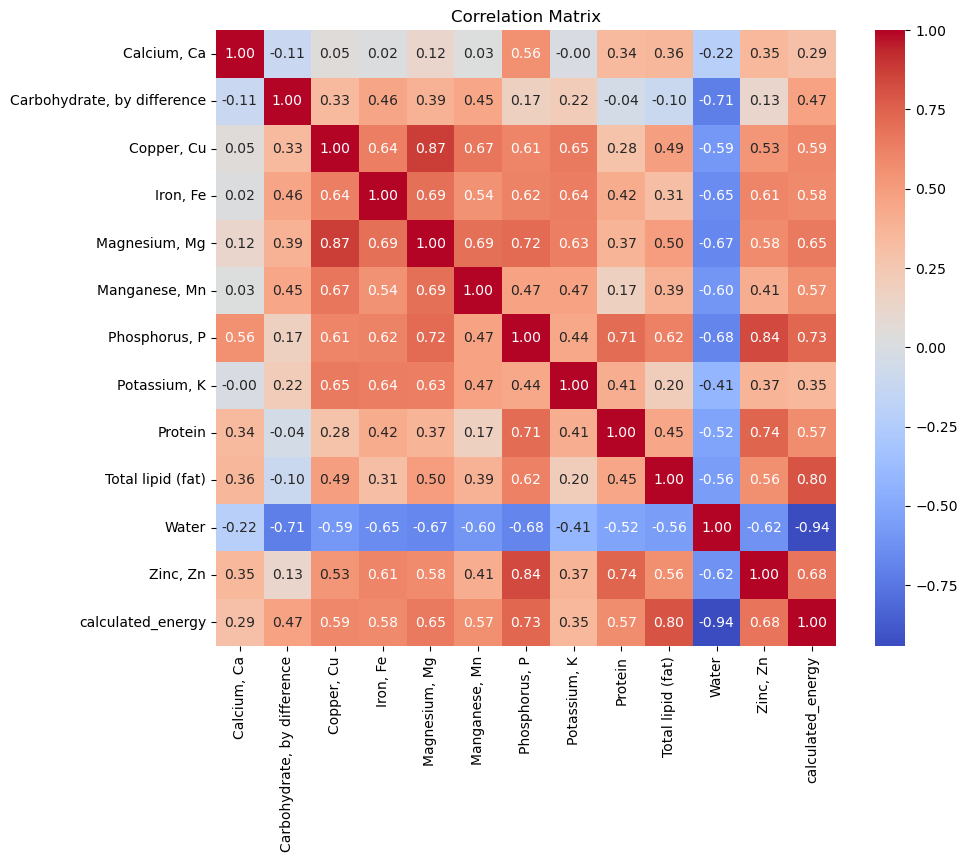

In [130]:
corr_matrix = scaled.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

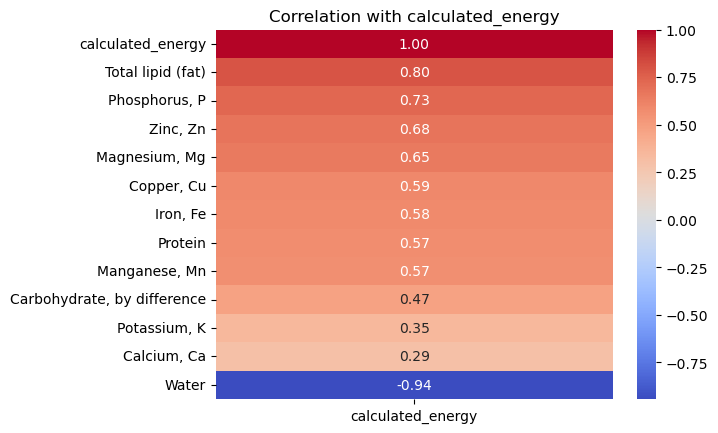

In [121]:
target =  'calculated_energy'
correlations = scaled.corr()[target].sort_values(ascending=False)

sns.heatmap(correlations.to_frame(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title(f'Correlation with {target}')
plt.show()

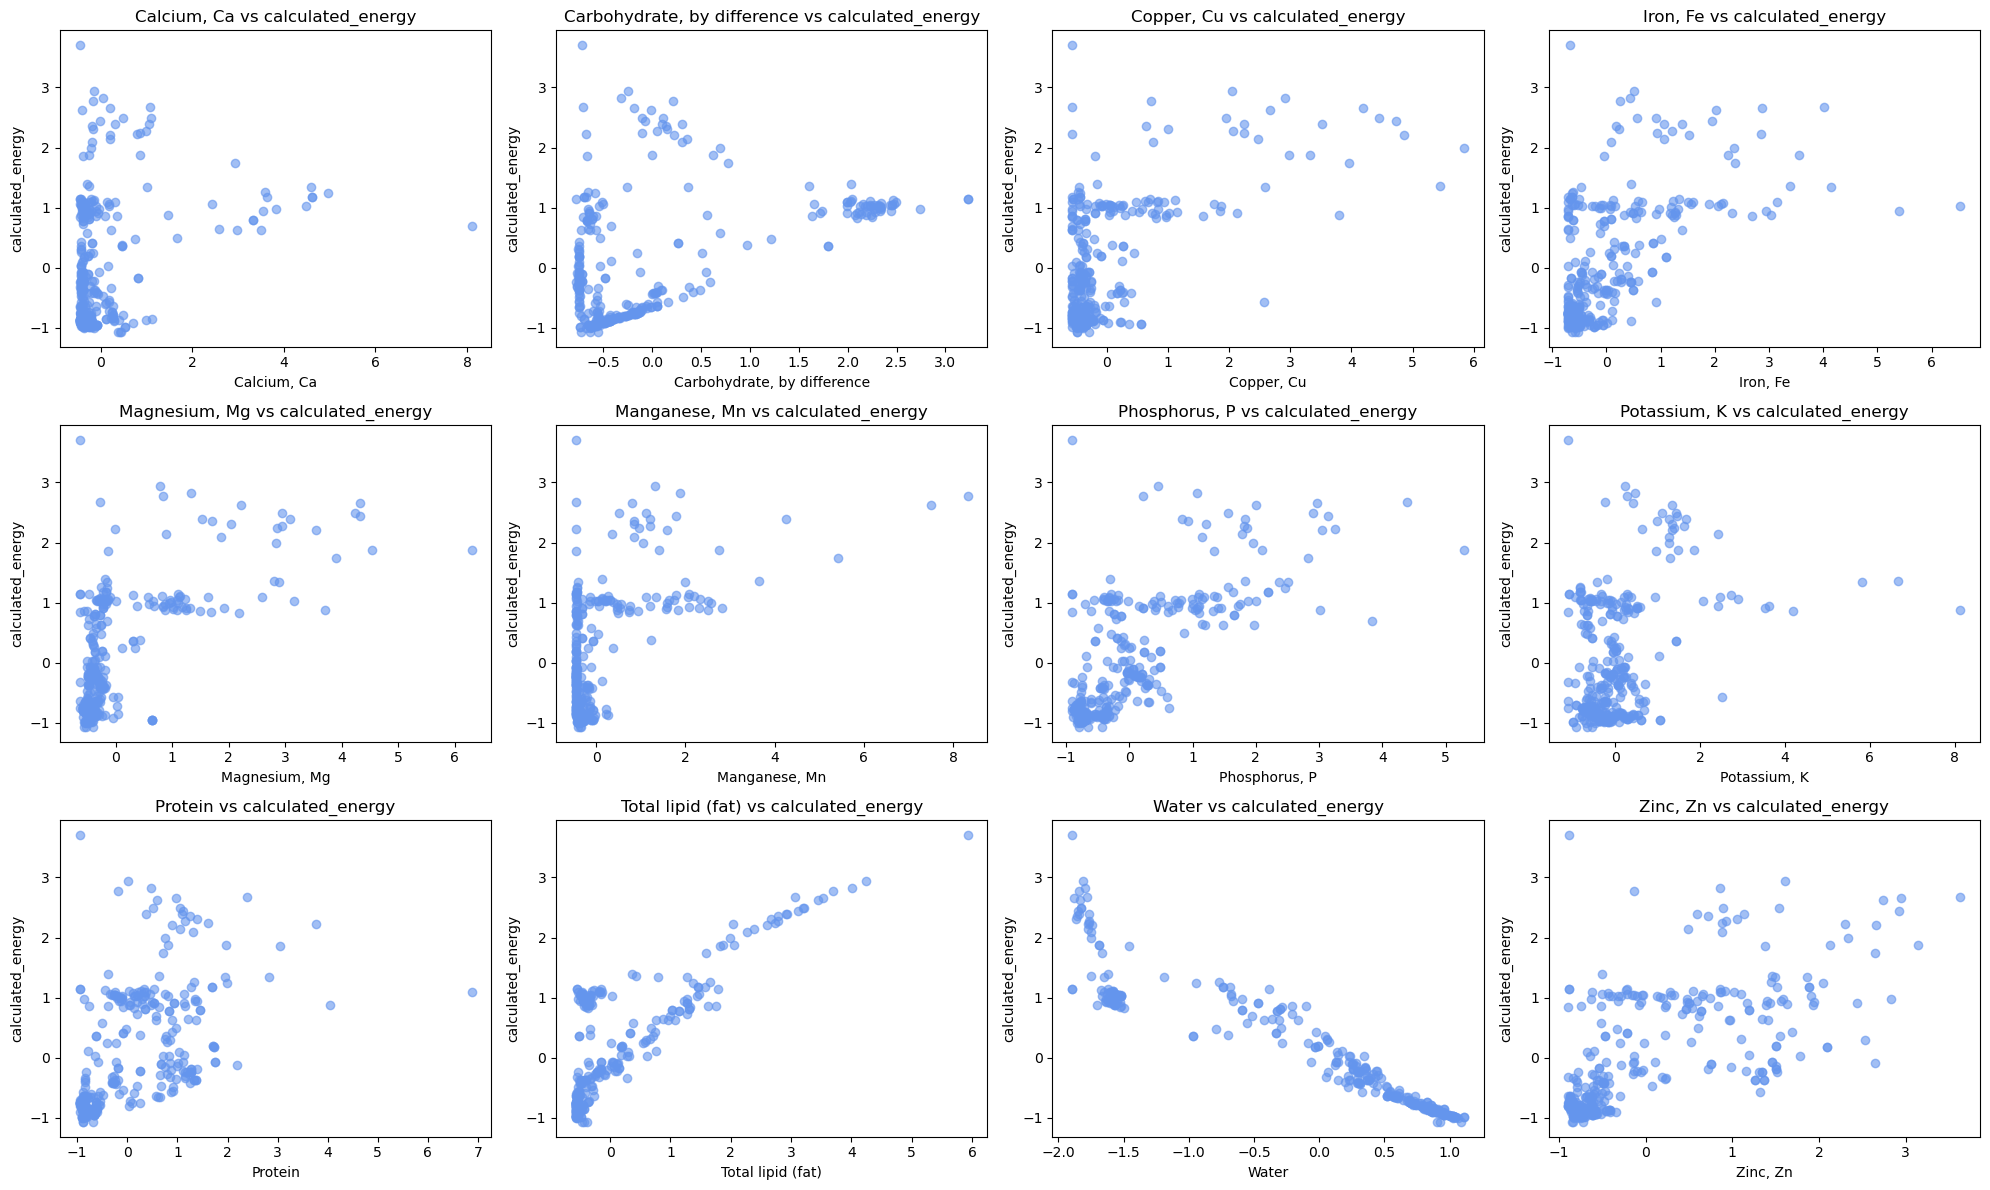

In [122]:
target =  'calculated_energy'
features = [col for col in scaled.columns if col != target]

n_cols = 4
n_rows = math.ceil(len(features) / n_cols) # number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()  # Flatten in case of multiple rows

for i, feature in enumerate(features):
    axes[i].scatter(scaled[feature], scaled[target], color='cornflowerblue', alpha=0.6)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(target)
    axes[i].set_title(f'{feature} vs {target}')

plt.tight_layout()
plt.show()

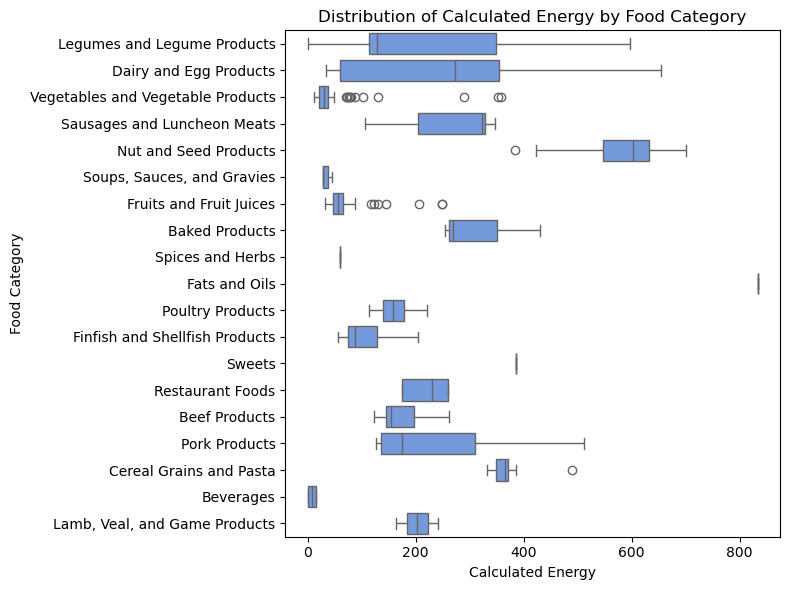

In [123]:
plt.figure(figsize=(8,6))

sns.boxplot(y='food_category', x='calculated_energy', data=foods, color='cornflowerblue')
plt.title('Distribution of Calculated Energy by Food Category')
plt.ylabel('Food Category')
plt.xlabel('Calculated Energy')
plt.tight_layout()
plt.show()

### Dataset Observations

- There is a wide range of ``calculated_energy`` values across different food categories, with some categories (e.g., 'Fats and Oils', 'Nut and Seed Products') showing much higher energy content than others (e.g., 'Vegetables and Vegetable Products', 'Soups, Sauces, and Gravies').
- Several features exhibit strong variability, suggesting a heterogeneous dataset with foods differing substantially in nutritional composition.

- The heatmap confirms the strongest correlations with ``calculated_energy`` are:
  - **Total lipid (fat) (0.80)** → high impact
  - **Water (-0.94)** → negative impact
  - **Phosphorus (0.73), Magnesium (0.65), Zinc (0.68)** → moderate positive impact

- Features like Carbohydrate (0.47) and Protein (0.57) have moderate positive influence.
- Overall, energy content is largely driven by fat and water content, with other nutrients providing secondary contributions.

### Modeling Implications

- Features with **strong correlations** (``Total lipid``, ``Water``) are likely the *most predictive for regression models* targeting ``calculated_energy``.
- Outliers in energy-rich categories (e.g., ``Fats and Oils``) should be considered for *robust regression or transformation*.
- Features with weak correlation can be *candidates for exclusion* or given lower importance in tree-based models.

## Modeling

In [158]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression

target = 'calculated_energy'
features = foods.drop(columns=['fdc_id', 'description', target]).columns

X_train, X_test, y_train, y_test = train_test_split(
    foods[features],
    foods[target],
    test_size=0.2,
    random_state=42)


### Pipeline

In [159]:
# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing for numerical and categorical data
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a pipeline that first preprocesses the data and then fits a model
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Another pipeline with RandomForestRegressor
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [ ]:
# Train the models
pipeline_lr.fit(X_train, y_train)
pipeline_rf.fit(X_train, y_train)

In [163]:
# Predictions
y_pred_lr = pipeline_lr.predict(X_test)
y_pred_rf = pipeline_rf.predict(X_test)

# avaliation
mse_lr = mean_squared_error(y_test, y_pred_lr)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_lr = r2_score(y_test, y_pred_lr)
r2_rf = r2_score(y_test, y_pred_rf)

rmse_lr = root_mean_squared_error(y_test, y_pred_lr)
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)

print(f'MSE Linear Regression: {mse_lr:.4f} | R²: {r2_lr:.4f}')
print(f'MSE Random Forest: {mse_rf:.4f} | R²: {r2_rf:.4f}')
print('='*50)
print(f'RMSE Linear Regression: {rmse_lr:.4f}')
print(f'RMSE Random Forest: {rmse_rf:.4f}')
print('='*50)
print(f'r2_score Linear Regression: {r2_lr:.4f}')
print(f'r2_score Random Forest: {r2_rf:.4f}')

MSE Linear Regression: 32.0826 | R²: 0.9989
MSE Random Forest: 746.9453 | R²: 0.9749
RMSE Linear Regression: 5.6642
RMSE Random Forest: 27.3303
r2_score Linear Regression: 0.9989
r2_score Random Forest: 0.9749


In [192]:
# Predictions oon train set
y_train_pred_lr = pipeline_lr.predict(X_train)
y_train_pred_rf = pipeline_rf.predict(X_train)

# avaliation for train set
mse_lr = mean_squared_error(y_train, y_train_pred_lr)
mse_rf = mean_squared_error(y_train, y_train_pred_rf)
r2_lr = r2_score(y_train, y_train_pred_lr)
r2_rf = r2_score(y_train, y_train_pred_rf)

rmse_lr = root_mean_squared_error(y_train, y_train_pred_lr)
rmse_rf = root_mean_squared_error(y_train, y_train_pred_rf)

print(f'MSE Linear Regression: {mse_lr:.4f} | R²: {r2_lr:.4f}')
print(f'MSE Random Forest: {mse_rf:.4f} | R²: {r2_rf:.4f}')
print('='*50)
print(f'RMSE Linear Regression: {rmse_lr:.4f}')
print(f'RMSE Random Forest: {rmse_rf:.4f}')
print('='*50)
print(f'r2_score Linear Regression: {r2_lr:.4f}')
print(f'r2_score Random Forest: {r2_rf:.4f}')

MSE Linear Regression: 36.9112 | R²: 0.9988
MSE Random Forest: 53.7037 | R²: 0.9982
RMSE Linear Regression: 6.0755
RMSE Random Forest: 7.3283
r2_score Linear Regression: 0.9988
r2_score Random Forest: 0.9982


In [164]:
X = foods[features]
y = foods[target]

# ===== Cross-validation with R² =====
cv_scores_lr = cross_val_score(pipeline_lr, X, y, cv=5, scoring='r2')
cv_scores_rf = cross_val_score(pipeline_rf, X, y, cv=5, scoring='r2')

print('\n=== Cross-Validation (5 folds) ===')
print(f'Linear Regression -> Média R²: {cv_scores_lr.mean():.4f} ± {cv_scores_lr.std():.4f}')
print(f'Random Forest     -> Média R²: {cv_scores_rf.mean():.4f} ± {cv_scores_rf.std():.4f}')


=== Cross-Validation (5 folds) ===
Linear Regression -> Média R²: 0.9973 ± 0.0009
Random Forest     -> Média R²: 0.9882 ± 0.0055


### Hyperparameter Tuning with GridSearchCV

In [171]:
# Parameter grid for RandomForestRegressor
param_grid = {
    'regressor__n_estimators': [100, 200, 500],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Calcium, '
                                                                          'Ca',
                                                                          'Carbohydrate, '
                                                                          'by '
                                                                          'difference',
                                                                          'Copper, '
                                                                          'Cu',
                                                                          'Iron, '
                                                                          'Fe',
                                                                          'Magnesium, '
                                                                          'Mg',
                                                                          'Manganese, '
                                                                          'Mn',
                                                                          'Phosphorus, '
                                                                          'P',
                                                                          'Potassium, '
                                                                          'K',
                                                                          'Protein',
                                                                          'Total '
                                                                          'lipid '
                                                                          '(fat)',
                                                                          'Water',
                                                                          'Zinc, '
                                                                          'Zn']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['food_category'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None, 10, 20, 30],
                         'regressor__max_features': ['sqrt', 'log2'],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5, 10],
                         'regressor__n_estimators': [100, 200, 500]},
             scoring='r2', verbose=2)

In [174]:
# best model and parameters
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# best model evaluation
y_pred_best = best_rf_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)


print('\n=== GridSearchCV Results ===')
for param, value in best_params.items():
    print(f'{param:<30}: {value}')

print('\n=== Best Model from GridSearchCV ===')
print(f'MSE: {mse_best:.4f}')
print(f'R²:  {r2_best:.4f}')


=== GridSearchCV Results ===
regressor__max_depth          : 10
regressor__max_features       : sqrt
regressor__min_samples_leaf   : 1
regressor__min_samples_split  : 2
regressor__n_estimators       : 500

=== Best Model from GridSearchCV ===
MSE: 1415.4314
R²:  0.9525


GridSearchCV did not improve the model's performance because the default RandomForestRegressor parameters were already well-suited for the dataset, and the hyperparameter space explored did not yield significantly better combinations. 

The model may have reached its optimal performance given the features and data quality, so further tuning had little effect. Additionally, Random Forests are robust to parameter changes, and the dataset may not have enough complexity or noise for hyperparameter optimization to make a noticeable difference.

### Feature Importance

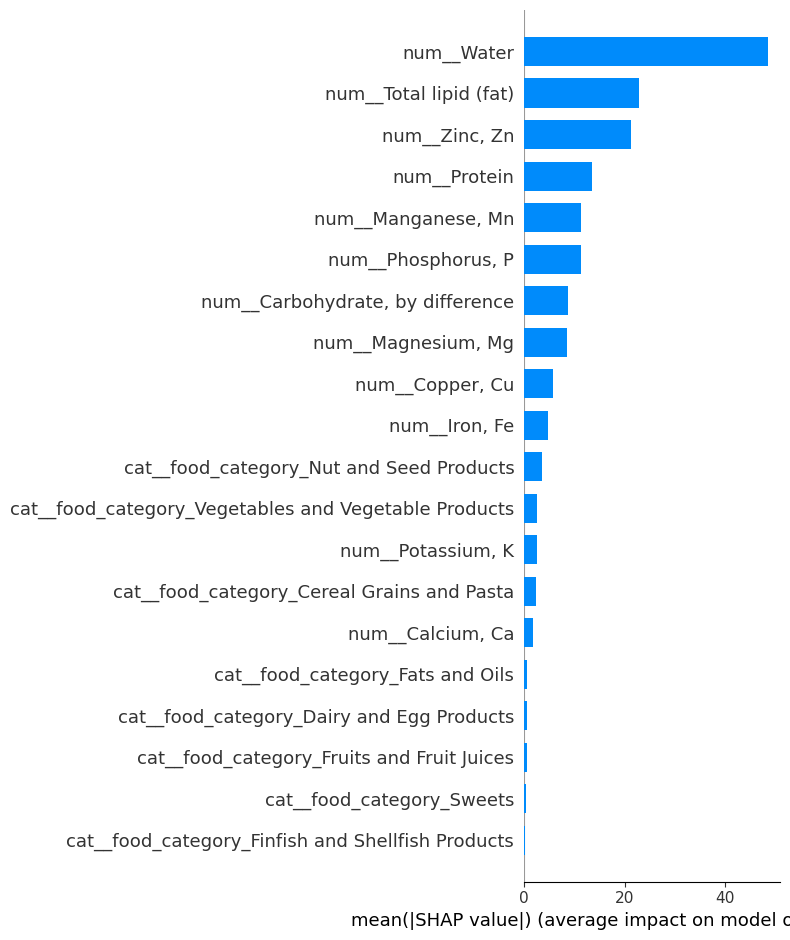

In [188]:
import shap

# Preprocess the training data
X_train_processed = preprocessor.transform(X_train)
feature_names = preprocessor.get_feature_names_out()

# Get feature importances using SHAP for random forest
explainer = shap.TreeExplainer(best_rf_model.named_steps['regressor'])
shap_values = explainer.shap_values(X_train_processed)
shap.summary_plot(shap_values, X_train_processed, feature_names=feature_names, plot_type='bar')

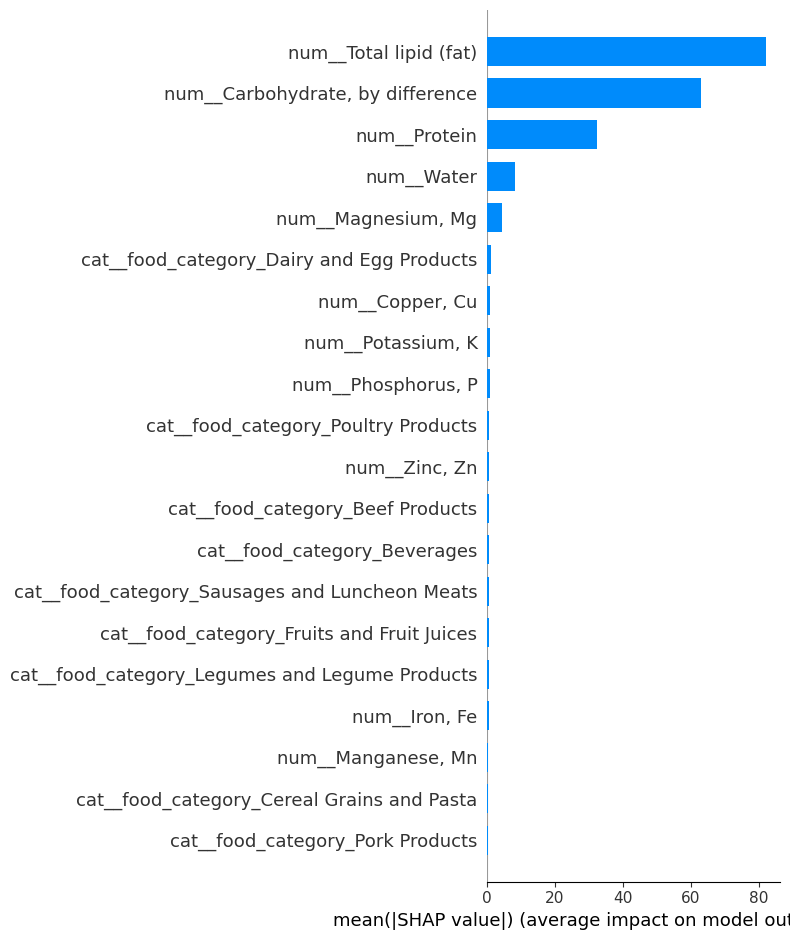

In [189]:
# Get feature importances using SHAP for linear regression
masker = shap.maskers.Independent(X_train_processed)
explainer = shap.LinearExplainer(pipeline_lr.named_steps['regressor'], masker=masker)
shap_values = explainer.shap_values(X_train_processed)
shap.summary_plot(shap_values, X_train_processed, feature_names=feature_names, plot_type='bar')

The SHAP summary plots reveal the following insights regarding `calculated_energy`:

- **Top contributing features:**
  - **Total lipid (fat)**
  - **Carbohydrates (by difference)**
  - **Protein**

  These are expected to be the most influential, as `calculated_energy` is directly derived from these macronutrients.

- **Other observations:**
  - **Water** also shows some importance. This is primarily because it does **not contribute to energy**, resulting in a negative relationship with total energy.

> **Insight:** The model correctly identifies the main energy-providing nutrients, while also recognizing features that inversely affect energy.


## Conclusions
